In [118]:
from mmcv import Config, DictAction
from mmrotate.datasets import build_dataset
from mmdet.datasets import build_dataloader

In [119]:
config = "/home/ntthanh/workspace/AO2-FIX/configs/deformable_detr/deformable_detr_cdn_r50_16x2_50e_dota.py"
cfg = Config.fromfile(config)
cfg.gpu_ids = range(1)
cfg.seed = 0

In [120]:
datasets = [build_dataset(cfg.data.train)]

In [121]:
dataset = datasets if isinstance(datasets, (list, tuple)) else [datasets]

runner_type = 'EpochBasedRunner' if 'runner' not in cfg else cfg.runner[
    'type']

train_dataloader_default_args = dict(
    samples_per_gpu=1,
    workers_per_gpu=2,
    # `num_gpus` will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    dist=False,
    seed=cfg.seed,
    runner_type=runner_type,
    persistent_workers=False)

train_loader_cfg = {
    **train_dataloader_default_args,
    **cfg.data.get('train_dataloader', {})
}

data_loaders = [build_dataloader(ds, **train_loader_cfg) for ds in dataset]

In [122]:
for sample in data_loaders[0]:
    print(sample)
    break

{'img_metas': DataContainer([[{'filename': '/home/ntthanh/workspace/data/split_1024_dota1_0/trainval/images/P0172__1024__1648___597.png', 'ori_filename': 'P0172__1024__1648___597.png', 'ori_shape': (1024, 1024, 3), 'img_shape': (1024, 1024, 3), 'pad_shape': (1024, 1024, 3), 'scale_factor': array([1., 1., 1., 1.], dtype=float32), 'flip': True, 'flip_direction': 'diagonal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]]), 'img': DataContainer([tensor([[[[-0.5938, -0.1999, -0.0972,  ..., -0.3712, -0.5082, -0.4911],
          [-0.4397, -0.4397, -0.2684,  ..., -0.5596, -0.6794, -0.6965],
          [-0.3712, -0.6794, -0.6452,  ..., -0.6452, -0.7479, -0.8678],
          ...,
          [-0.5938, -0.9020, -1.1760,  ...,  0.8618,  0.9474,  1.0331],
          [-0.5253, -0.7822, -1.1760,  ...,  0.9303,  0.8961,  0.9646],
          [-0.3712, -0.5424, -0.9192,  ...,  0.9646,  0.9132,  0.9646]],

  

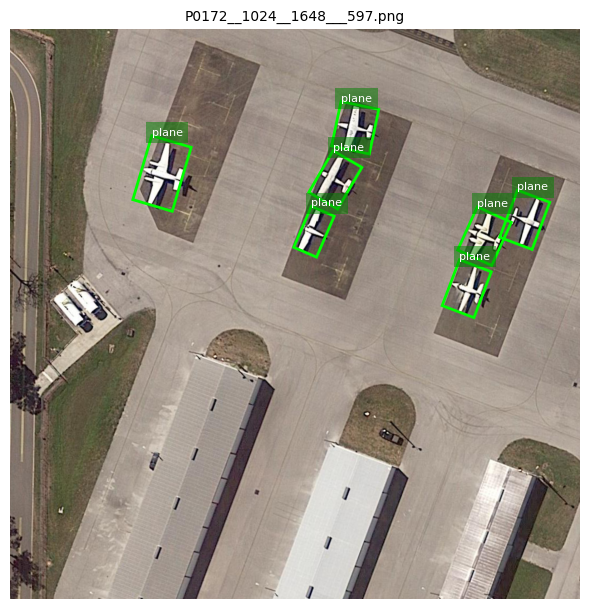

In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from mmrotate.core import obb2poly

CLASSES = (
        "plane",
        "baseball-diamond",
        "bridge",
        "ground-track-field",
        "small-vehicle",
        "large-vehicle",
        "ship",
        "tennis-court",
        "basketball-court",
        "storage-tank",
        "soccer-ball-field",
        "roundabout",
        "harbor",
        "swimming-pool",
        "helicopter",
    )

def denormalize_img(tensor, mean, std, to_rgb=True):
    """Denormalize tensor image using mean and std"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor = tensor.permute(1, 2, 0).numpy()
    return np.clip(tensor, 0, 255).astype(np.uint8)

def plot_result_with_polygons(result):
    img_metas = result['img_metas'].data[0]
    imgs = result['img'].data[0]
    all_bboxes = result['gt_bboxes'].data[0]
    all_labels = result['gt_labels'].data[0]

    # Lọc các ảnh có bbox
    valid_data = [
        (meta, img_tensor, bboxes_tensor, labels_tensor)
        for meta, img_tensor, bboxes_tensor, labels_tensor in zip(img_metas, imgs, all_bboxes, all_labels)
    ]

    if len(valid_data) == 0:
        print("Không có ảnh nào chứa ground-truth bounding boxes.")
        return

    num_images = len(valid_data)
    fig, axs = plt.subplots(1, num_images, figsize=(6 * num_images, 8))

    if num_images == 1:
        axs = [axs]  # Make it iterable

    for ax, (meta, img_tensor, bboxes, labels) in zip(axs, valid_data):
        # Denormalize image
        img = denormalize_img(
            img_tensor,
            mean=meta['img_norm_cfg']['mean'],
            std=meta['img_norm_cfg']['std'],
            to_rgb=meta['img_norm_cfg']['to_rgb']
        )

        polygons = obb2poly(bboxes)

        ax.imshow(img)
        ax.set_title(f"{meta['ori_filename']}", fontsize=10)
        ax.axis('off')

        for poly, label in zip(polygons, labels):
            points = poly[:8].reshape(4, 2)
            patch = patches.Polygon(
                points,
                linewidth=2,
                edgecolor='lime',
                facecolor='none'
            )
            ax.add_patch(patch)
            ax.text(
                points[0][0],
                points[0][1],
                CLASSES[label],
                color='white',
                fontsize=8,
                bbox=dict(facecolor='green', alpha=0.5, edgecolor='none')
            )

    plt.tight_layout()
    plt.show()


plot_result_with_polygons(sample)


In [124]:
from mmrotate.core import obb2poly, poly2obb

import torch

gt_bboxes = sample['gt_bboxes'].data[0]
gt_labels = sample['gt_labels'].data[0]
targets = [{'image_id': i, 'boxes': gt_bboxes[i], 'labels': gt_labels[i]} for i in range(len(gt_bboxes))]

In [125]:
def inverse_sigmoid(x, eps=1e-5):
    """
    Inverse sigmoid function.
    Args:
        x (Tensor): Input tensor.
        eps (float): Small value to avoid division by zero.
    Returns:
        Tensor: Inverse sigmoid of the input tensor.
    """
    x = x.clamp(min=0, max=1)
    x1 = x.clamp(min=eps)
    x2 = (1 - x).clamp(min=eps)
    return torch.log(x1 / x2)

def prepare_for_cdn(dn_args, training, num_queries, num_classes, hidden_dim, label_enc):
    """
    A major difference of DINO from DN-DETR is that the author process pattern embedding in its detector
    forward function and use learnable tgt embedding, so we change this function a little bit.
    :param dn_args: targets, dn_number, label_noise_ratio, box_noise_scale
    :param training: if it is training or inference
    :param num_queries: number of queires
    :param num_classes: number of classes
    :param hidden_dim: transformer hidden dim
    :param label_enc: encode labels in dn
    :return:
    """
    if not training:
        return None, None, None, None
    
    targets, dn_number, label_noise_ratio, box_noise_scale, angle_noise_range = dn_args
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
        
    # Tính toán số lượng positive samples
    known = [torch.ones_like(t["labels"]).to(device) for t in targets]
    batch_size = len(known)
    known_num = [sum(k) for k in known]
    max_known = int(max(known_num))
    
    # Điều chỉnh dn_number
    dn_number = dn_number * 2
    if max_known == 0:
        dn_number = 1
    elif dn_number >= 100:
        dn_number = max(1, dn_number // (max_known * 2))
    elif dn_number < 1:
        dn_number = 1
    
    # Gom nhóm dữ liệu
    unmask_bbox = unmask_label = torch.cat(known)
    labels = torch.cat([t["labels"] for t in targets])
    boxes = torch.cat([t["boxes"] for t in targets])
    img_size = 1024  # Kích thước ảnh
    boxes[:, :4] = boxes[:, :4] / img_size  # Chuyển về [0, 1]
    batch_idx = torch.cat([torch.full_like(t["labels"].long(), i) for i, t in enumerate(targets)])

    # Tạo indices
    known_indice = torch.nonzero(unmask_label + unmask_bbox).view(-1)
    known_indice = known_indice.repeat(2 * dn_number, 1).view(-1)
    known_labels = labels.repeat(2 * dn_number, 1).view(-1)
    known_bid = batch_idx.repeat(2 * dn_number, 1).view(-1).to(device)
    known_bboxs = boxes.repeat(2 * dn_number, 1)
    known_labels_expaned = known_labels.clone()
    known_bbox_expand = known_bboxs.clone()
    
    # Thêm nhiễu vào labels nếu cần
    if label_noise_ratio > 0:
        p = torch.rand_like(known_labels_expaned.float())
        chosen_indice = torch.nonzero(p < (label_noise_ratio * 0.5)).view(-1)  # half of bbox prob
        new_label = torch.randint_like(chosen_indice, 0, num_classes)  # randomly put a new one here
        known_labels_expaned.scatter_(0, chosen_indice, new_label)
    
    # Chuẩn bị padding 
    single_pad = max_known
    pad_size = int(single_pad * 2 * dn_number)
    
    # Tạo positive và negative indices
    positive_idx = torch.arange(len(boxes), device=device).unsqueeze(0).repeat(dn_number, 1)
    positive_idx += (torch.arange(dn_number, device=device) * len(boxes) * 2).unsqueeze(1)
    positive_idx = positive_idx.flatten()
    negative_idx = positive_idx + len(boxes)
    
    
    # Thêm nhiễu vào bounding boxes
    if box_noise_scale > 0:
        # Chuyển đổi từ định dạng (cx, cy, w, h, angle) sang 8 điểm (xyxyxyxy)
        known_bbox_poly = obb2poly(known_bboxs)
        
        # Tính toán tâm của đối tượng
        center_x = (known_bbox_poly[:, 0] + known_bbox_poly[:, 2] + known_bbox_poly[:, 4] + known_bbox_poly[:, 6]) / 4
        center_y = (known_bbox_poly[:, 1] + known_bbox_poly[:, 3] + known_bbox_poly[:, 5] + known_bbox_poly[:, 7]) / 4
        centers = torch.stack([center_x, center_y], dim=1)
        
        # Tính vector từ tâm đến mỗi điểm góc
        vectors = torch.zeros_like(known_bbox_poly)
        for i in range(0, 8, 2):
            vectors[:, i] = known_bbox_poly[:, i] - centers[:, 0]
            vectors[:, i+1] = known_bbox_poly[:, i+1] - centers[:, 1]
        
        # Tạo nhiễu cho các vector (giữ nguyên hình dạng)
        # Tạo 4 cặp nhiễu cho 4 góc
        noise_scale = (torch.ones_like(vectors) * box_noise_scale)
        negative_idx = negative_idx.to('cpu')
        noise_scale[negative_idx] *= 2.0  # Nhiễu lớn hơn cho negative samples
        
        # Tạo nhiễu ngẫu nhiên với dấu
        rand_sign = torch.randint_like(vectors, low=0, high=2, dtype=torch.float32) * 2.0 - 1.0
        rand_part = torch.rand_like(vectors)
        
        # Đảm bảo các góc cùng phía nhận cùng một nhiễu
        # Tạo 4 nhiễu khác nhau cho 4 góc
        corner_noise = torch.zeros_like(vectors)
        for i in range(4):
            # Tạo nhiễu cho góc thứ i
            noise_i = rand_sign[:, i*2:i*2+2] * rand_part[:, i*2:i*2+2] * noise_scale[:, i*2:i*2+2]
            corner_noise[:, i*2:i*2+2] = noise_i
        
        # Áp dụng nhiễu vào các vector
        scaled_vectors = vectors * (1.0 + corner_noise)
        
        # Tính toán các điểm mới từ tâm và vector đã thêm nhiễu
        new_points = torch.zeros_like(known_bbox_poly)
        for i in range(0, 8, 2):
            new_points[:, i] = centers[:, 0] + scaled_vectors[:, i]
            new_points[:, i+1] = centers[:, 1] + scaled_vectors[:, i+1]
        
        # Đảm bảo các điểm nằm trong khoảng [0, 1]
        known_bbox_poly = new_points.clamp(min=0.0, max=1.0)
        print(known_bbox_poly.shape)
        # Chuyển đổi lại từ 8 điểm sang định dạng ban đầu
        # for i, poly in enumerate(known_bbox_poly):
        #     rbbox = poly2obb(poly)
        #     known_bbox_expand[i] = rbbox
        known_bbox_expand = poly2obb(known_bbox_poly)
        print(known_bbox_expand.shape)
    # Chuẩn bị embeddings
    label_enc = label_enc.to(device)
    m = known_labels_expaned.long().to(device)
    input_label_embed = label_enc(m)
    
    # Sử dụng inverse_sigmoid cho các tọa độ trong khoảng [0, 1]
    known_bbox_expand_normalized = known_bbox_expand.clone()
    known_bbox_expand_normalized[:, :4] = known_bbox_expand[:, :4].clamp(0.01, 0.99)  # Tránh các giá trị 0 hoặc 1
    input_bbox_embed = inverse_sigmoid(known_bbox_expand_normalized).to(device)
    
    # Padding
    padding_label = torch.zeros(pad_size, hidden_dim, device=device)
    padding_bbox = torch.zeros(pad_size, boxes.size(1), device=device)
    
    input_query_label = padding_label.repeat(batch_size, 1, 1)
    input_query_bbox = padding_bbox.repeat(batch_size, 1, 1)

    # Ánh xạ indices
    map_known_indice = torch.tensor([], device=device)
    if known_num:
        map_known_indice = torch.cat([torch.arange(num, device=device) for num in known_num])
        map_known_indice = torch.cat([map_known_indice + single_pad * i for i in range(2 * dn_number)]).long()
    
    if len(known_bid):
        input_query_label[(known_bid.long(), map_known_indice)] = input_label_embed
        input_query_bbox[(known_bid.long(), map_known_indice)] = input_bbox_embed
    
    # Tạo attention mask với cải tiến để ngăn thông tin rò rỉ tốt hơn
    tgt_size = pad_size + num_queries
    attn_mask = torch.ones(tgt_size, tgt_size, device=device) < 0
    
    # Match query không thể thấy reconstruct
    attn_mask[pad_size:, :pad_size] = True
    
    # Reconstruct không thể thấy nhau
    for i in range(dn_number):
        start_idx = single_pad * 2 * i
        end_idx = single_pad * 2 * (i + 1)
        
        if i == 0:
            attn_mask[start_idx:end_idx, end_idx:pad_size] = True
        elif i == dn_number - 1:
            attn_mask[start_idx:end_idx, :start_idx] = True
        else:
            attn_mask[start_idx:end_idx, end_idx:pad_size] = True
            attn_mask[start_idx:end_idx, :start_idx] = True

    dn_meta = {
        "pad_size": pad_size,
        "num_dn_group": dn_number,
    }
    
    return input_query_label, input_query_bbox, attn_mask, dn_meta, known_bbox_expand, positive_idx, negative_idx

In [126]:
def prepare_for_cdn_dino(dn_args, training, num_queries, num_classes, hidden_dim, label_enc):
    if not training:
        return None, None, None, None

    targets, dn_number, label_noise_ratio, box_noise_scale, angle_noise_range = dn_args
    device = label_enc.weight.device  # Đồng bộ device từ label_enc (hoặc dùng torch.cuda.current_device())

    # Tính toán số lượng positive samples
    known = [torch.ones_like(t["labels"]).to(device) for t in targets]
    batch_size = len(known)
    known_num = [sum(k) for k in known]
    max_known = int(max(known_num))

    # Điều chỉnh dn_number
    dn_number = dn_number * 2
    if max_known == 0:
        dn_number = 1
    elif dn_number >= 100:
        dn_number = max(1, dn_number // (max_known * 2))
    elif dn_number < 1:
        dn_number = 1

    # Gom nhóm dữ liệu
    labels = torch.cat([t["labels"].to(device) for t in targets])
    boxes = torch.cat([t["boxes"].to(device) for t in targets])
    img_size = 1024
    boxes[:, :4] = boxes[:, :4] / img_size
    batch_idx = torch.cat([torch.full_like(t["labels"].long(), i, device=device) for i, t in enumerate(targets)])

    unmask_bbox = unmask_label = torch.ones_like(labels, device=device)
    known_indice = torch.nonzero(unmask_label + unmask_bbox, as_tuple=False).view(-1)

    known_indice = known_indice.repeat(2 * dn_number, 1).view(-1)
    known_labels = labels.repeat(2 * dn_number, 1).view(-1)
    known_bid = batch_idx.repeat(2 * dn_number, 1).view(-1)
    known_bboxs = boxes.repeat(2 * dn_number, 1)

    known_labels_expaned = known_labels.clone()
    known_bbox_expand = known_bboxs.clone()

    # Thêm nhiễu vào labels
    if label_noise_ratio > 0:
        p = torch.rand_like(known_labels_expaned.float())
        chosen_indice = torch.nonzero(p < (label_noise_ratio * 0.5), as_tuple=False).view(-1)
        new_label = torch.randint(0, num_classes, (chosen_indice.shape[0],), device=device)
        known_labels_expaned.scatter_(0, chosen_indice, new_label)

    single_pad = max_known
    pad_size = int(single_pad * 2 * dn_number)

    # Tạo positive và negative indices
    positive_idx = torch.arange(len(boxes), device=device).unsqueeze(0).repeat(dn_number, 1)
    positive_idx += (torch.arange(dn_number, device=device) * len(boxes) * 2).unsqueeze(1)
    positive_idx = positive_idx.flatten()
    negative_idx = positive_idx + len(boxes)

    # Thêm nhiễu vào bounding boxes
    if box_noise_scale > 0:
        known_bbox_poly = obb2poly(known_bboxs)

        diff = torch.zeros_like(known_bboxs[:, :4])
        diff[:, :2] = known_bboxs[:, 2:4] / 2
        diff[:, 2:] = known_bboxs[:, 2:4] / 2

        rand_sign = torch.randint_like(known_bboxs[:, :4], low=0, high=2, dtype=torch.float32) * 2.0 - 1.0
        rand_part = torch.rand_like(known_bboxs[:, :4])
        rand_part[negative_idx] += 1.0
        rand_part *= rand_sign
        noise = torch.mul(rand_part, diff) * box_noise_scale

        known_bbox_poly[:, :2] += noise[:, :2]
        known_bbox_poly[:, 2:4] += noise[:, 2:4]
        known_bbox_poly[:, 4:6] += noise[:, :2]
        known_bbox_poly[:, 6:8] += noise[:, 2:4]

        known_bbox_expand = poly2obb(known_bbox_poly)

    # Tạo embeddings
    input_label_embed = label_enc(known_labels_expaned.long())
    
    known_bbox_expand_normalized = known_bbox_expand.clone()
    known_bbox_expand_normalized[:, :4] = known_bbox_expand[:, :4].clamp(0.01, 0.99)
    input_bbox_embed = inverse_sigmoid(known_bbox_expand_normalized)

    # Padding
    input_query_label = torch.zeros(batch_size, pad_size, hidden_dim, device=device)
    input_query_bbox = torch.zeros(batch_size, pad_size, boxes.size(1), device=device)

    # Ánh xạ indices
    map_known_indice = torch.tensor([], device=device)
    if known_num:
        map_known_indice = torch.cat([torch.arange(num, device=device) for num in known_num])
        map_known_indice = torch.cat([map_known_indice + single_pad * i for i in range(2 * dn_number)]).long()

    if len(known_bid):
        input_query_label[(known_bid.long(), map_known_indice)] = input_label_embed
        input_query_bbox[(known_bid.long(), map_known_indice)] = input_bbox_embed

    # Tạo attention mask
    tgt_size = pad_size + num_queries
    attn_mask = torch.ones(tgt_size, tgt_size, device=device) < 0
    attn_mask[pad_size:, :pad_size] = True

    for i in range(dn_number):
        start_idx = single_pad * 2 * i
        end_idx = single_pad * 2 * (i + 1)
        if i == 0:
            attn_mask[start_idx:end_idx, end_idx:pad_size] = True
        elif i == dn_number - 1:
            attn_mask[start_idx:end_idx, :start_idx] = True
        else:
            attn_mask[start_idx:end_idx, :start_idx] = True
            attn_mask[start_idx:end_idx, end_idx:pad_size] = True

    dn_meta = {
        "pad_size": pad_size,
        "num_dn_group": dn_number,
    }

    return input_query_label, input_query_bbox, attn_mask, dn_meta, known_bbox_expand, positive_idx, negative_idx


In [127]:
from torch import nn

dn_number=100
dn_box_noise_scale=0.4
dn_label_noise_ratio=0.5
dn_angle_noise_range=15
dn_labelbook_size=100
label_enc = nn.Embedding(dn_labelbook_size + 1, 256).to("cuda")
dn_args = (targets, dn_number, dn_label_noise_ratio, dn_box_noise_scale, dn_angle_noise_range)
input_query_label, input_query_bbox, attn_mask, dn_meta, known_bbox_expand, positive_idx, negative_idx = prepare_for_cdn(dn_args, True, 250, 15, 256, label_enc)

cuda
torch.Size([196, 8])
torch.Size([196, 5])


In [128]:
input_query_bbox[0][:5], input_query_label[0][:5]
input_query_label.shape, input_query_bbox.shape

(torch.Size([1, 196, 256]), torch.Size([1, 196, 5]))

In [129]:
known_bbox_expand = known_bbox_expand.to('cuda')
positive_bboxes = known_bbox_expand[positive_idx]
negative_bboxes  = known_bbox_expand[negative_idx]
len(positive_bboxes), len(negative_bboxes)

(98, 98)

torch.Size([98, 5]) torch.Size([98, 5])
(98, 8) (98, 8)


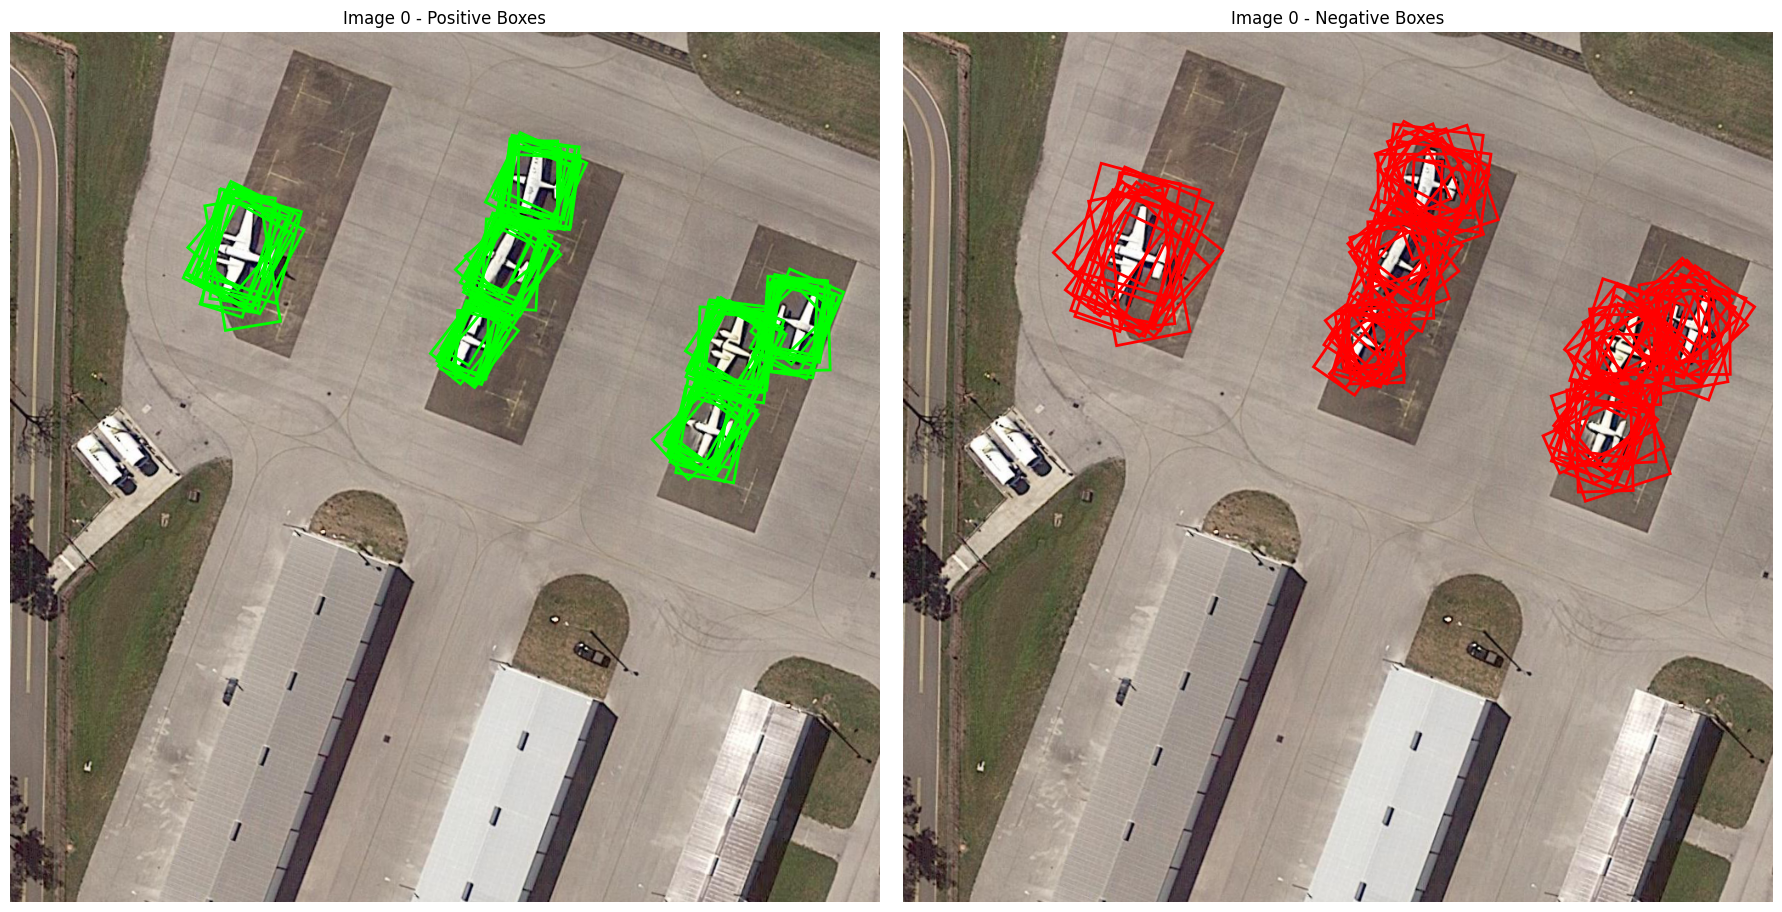

In [130]:
def denormalize_bboxes(bboxes, img_size=1024):
    """Chuyển tọa độ từ [0,1] về pixel"""
    tmp = bboxes.clone()
    tmp[:, :4] = tmp[:, :4] * img_size
    return tmp

def plot_result_with_positive_negative(sample, denorm_pos_neg_bboxes):
    num_imgs = len(sample['img_metas'].data[0])
    
    fig, axs = plt.subplots(
        num_imgs, 2, figsize=(18, 9 * num_imgs)
    )  # 2 cột (pos/neg), mỗi ảnh là 1 hàng

    # Trường hợp chỉ có 1 ảnh thì axs không phải mảng 2D, nên cần reshape
    if num_imgs == 1:
        axs = np.expand_dims(axs, axis=0)

    for idx in range(num_imgs):
        meta = sample['img_metas'].data[0][idx]
        img_tensor = sample['img'].data[0][idx]

        # Denormalize image
        img = denormalize_img(
            img_tensor,
            mean=meta['img_norm_cfg']['mean'],
            std=meta['img_norm_cfg']['std'],
            to_rgb=meta['img_norm_cfg']['to_rgb']
        )

        pos_polygons, neg_polygons = denorm_pos_neg_bboxes[idx]
        print(pos_polygons.shape, neg_polygons.shape)

        # Positive box
        axs[idx][0].imshow(img)
        axs[idx][0].set_title(f"Image {idx} - Positive Boxes")
        axs[idx][0].axis('off')
        if pos_polygons is not None and len(pos_polygons) > 0:
            for poly in pos_polygons:
                points = poly[:8].reshape(4, 2)
                polygon_patch = patches.Polygon(
                    points,
                    linewidth=2,
                    edgecolor='lime',
                    facecolor='none'
                )
                axs[idx][0].add_patch(polygon_patch)

        # Negative box
        axs[idx][1].imshow(img)
        axs[idx][1].set_title(f"Image {idx} - Negative Boxes")
        axs[idx][1].axis('off')
        if neg_polygons is not None and len(neg_polygons) > 0:
            for poly in neg_polygons:
                points = poly[:8].reshape(4, 2)
                polygon_patch = patches.Polygon(
                    points,
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none'
                )
                axs[idx][1].add_patch(polygon_patch)

    plt.tight_layout()
    plt.show()


# Denormalize positive and negative bboxes and convert to polygons
denorm_pos_neg_bboxes = []
for i in range(len(sample['img_metas'].data[0])):
    positive_bboxes = known_bbox_expand[positive_idx[i*100:(i+1)*100]]
    negative_bboxes = known_bbox_expand[negative_idx[i*100:(i+1)*100]]
    print(positive_bboxes.shape, negative_bboxes.shape)
    denorm_positive_bboxes = denormalize_bboxes(positive_bboxes, img_size=1024)
    denorm_positive_bboxes_poly = obb2poly(denorm_positive_bboxes).cpu().numpy()
    denorm_negative_bboxes = denormalize_bboxes(negative_bboxes, img_size=1024)
    denorm_negative_bboxes_poly = obb2poly(denorm_negative_bboxes).cpu().numpy()
    denorm_pos_neg_bboxes.append((denorm_positive_bboxes_poly, denorm_negative_bboxes_poly))

# denorm_pos_neg_bboxes
# Call plotting function
plot_result_with_positive_negative(sample, denorm_pos_neg_bboxes)

In [131]:
from torch import nn

dn_number=100
dn_box_noise_scale=0.4
dn_label_noise_ratio=0.5
dn_angle_noise_range=15
dn_labelbook_size=100
label_enc = nn.Embedding(dn_labelbook_size + 1, 256)
dn_args = (targets, dn_number, dn_label_noise_ratio, dn_box_noise_scale, dn_angle_noise_range)
input_query_label_dino, input_query_bbox_dino, attn_mask_dino, dn_meta_dino, known_bbox_expand_dino, positive_idx_dino, negative_idx_dino = prepare_for_cdn_dino(dn_args, True, 250, 15, 256, label_enc)

In [132]:
known_bbox_expand_dino = known_bbox_expand_dino.to('cuda')
positive_bboxes_dino = known_bbox_expand_dino[positive_idx_dino]
negative_bboxes_dino  = known_bbox_expand_dino[negative_idx_dino]

torch.Size([98, 5]) torch.Size([98, 5])
(98, 8) (98, 8)


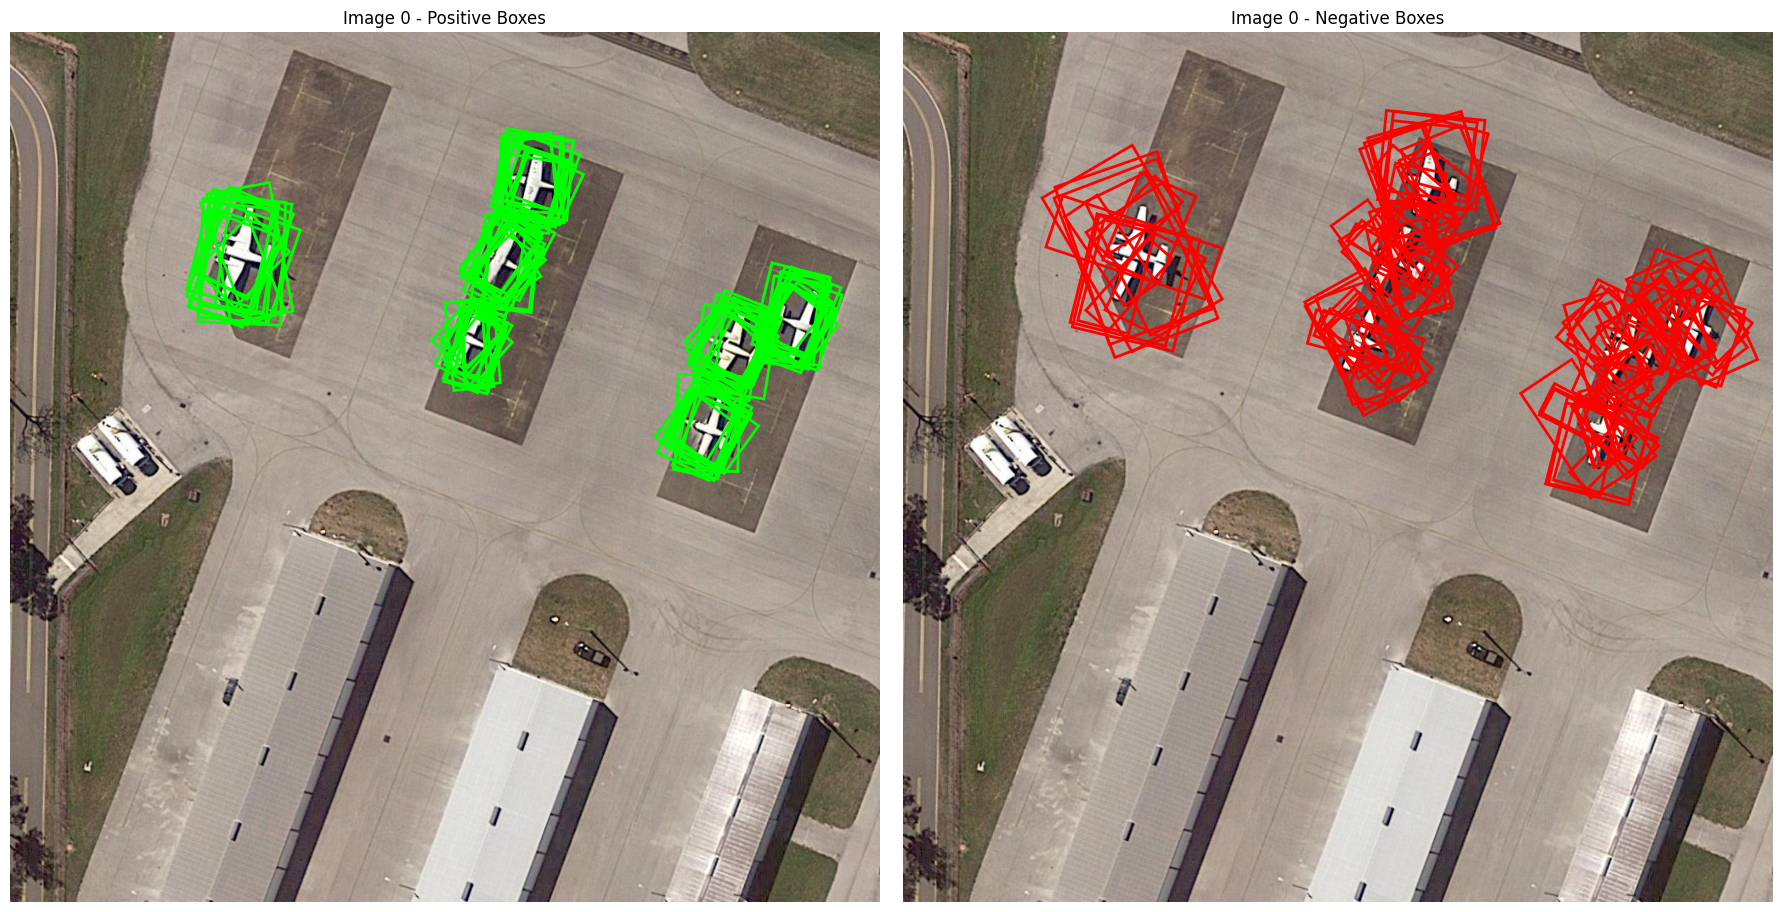

In [133]:
denorm_pos_neg_bboxes_dino = []
for i in range(len(sample['img_metas'].data[0])):
    positive_bboxes_dino = known_bbox_expand_dino[positive_idx_dino[i*100:(i+1)*100]]
    negative_bboxes_dino = known_bbox_expand_dino[negative_idx_dino[i*100:(i+1)*100]]
    print(positive_bboxes_dino.shape, negative_bboxes_dino.shape)
    denorm_positive_bboxes = denormalize_bboxes(positive_bboxes_dino, img_size=1024)
    denorm_positive_bboxes_poly = obb2poly(denorm_positive_bboxes).cpu().numpy()
    denorm_negative_bboxes = denormalize_bboxes(negative_bboxes_dino, img_size=1024)
    denorm_negative_bboxes_poly = obb2poly(denorm_negative_bboxes).cpu().numpy()
    denorm_pos_neg_bboxes_dino.append((denorm_positive_bboxes_poly, denorm_negative_bboxes_poly))

# Call plotting function
plot_result_with_positive_negative(sample, denorm_pos_neg_bboxes_dino)